In [3]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from itertools import product
import matplotlib.pyplot as plt

In [4]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the figure suptitle
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
def mean_euclidean_error(vectors1, vectors2):
    """
    Compute the mean Euclidean error between two sets of 3D vectors.

    Parameters:
    - vectors1: NumPy array of shape (N, 3) representing the first set of 3D vectors
    - vectors2: NumPy array of shape (N, 3) representing the second set of 3D vectors

    Returns:
    - mean_error: Mean Euclidean error between the two sets of vectors
    """
    # Check if the input arrays have the correct shape
    if vectors1.shape != vectors2.shape or vectors1.shape[1] != 3:
        raise ValueError("Input arrays must be of shape (N, 3)")

    # Compute Euclidean distance
    euclidean_distance = np.linalg.norm(vectors1 - vectors2, axis=1)

    # Calculate the mean Euclidean error
    mean_error = np.mean(euclidean_distance)

    return mean_error

Since the output is 3-dimensional, our model is composed of three SVMs.
We create a class to make things easier:


In [6]:
class MultiSVM:
    """
    A wrapper class for multiple Support Vector Regressors (SVRs) with shared hyperparameters.

    Parameters:
    - kernel (str, optional): Specifies the kernel type ('linear', 'poly', 'rbf', 'sigmoid', etc.).
    - C (float, optional): Regularization parameter. Controls the trade-off between smooth decision function and fitting the training data.
    - epsilon (float, optional): Width of the epsilon-insensitive tube. Ignored errors within this range during training.
    - degree (int, optional): Degree of the polynomial kernel. Only applicable for 'poly' kernel.

    Attributes:
    - svr0, svr1, svr2: Support Vector Regressors for each target dimension.

    Methods:
    - fit(X, y): Fit each SVR on its respective target dimension.
    - predict(X): Make predictions using each SVR and return a stacked array of predictions.
    """

    def __init__(self, kernel='rbf', C=1.0, epsilon=0.1, degree=3, gamma='scale'):
        # Create three support vector regressors with the specified kernel, regularization parameter, and epsilon
        self.svr0 = SVR(kernel=kernel, C=C, epsilon=epsilon, degree=degree, gamma=gamma)
        self.svr1 = SVR(kernel=kernel, C=C, epsilon=epsilon, degree=degree, gamma=gamma)
        self.svr2 = SVR(kernel=kernel, C=C, epsilon=epsilon, degree=degree, gamma=gamma)

    def fit(self, X, y):
        # Fit each SVR on its respective data
        self.svr0.fit(X, y[:,0])
        self.svr1.fit(X, y[:,1])
        self.svr2.fit(X, y[:,2])

    def predict(self, X):
        # Make predictions using each SVR
        pred = np.column_stack((self.svr0.predict(X),self.svr1.predict(X),self.svr2.predict(X)))
        return pred

In [7]:
def perform_grid_search_kfold(kernels, Cs, epsilons, degrees,gammas, k_folds, x, y, return_sequence=False):
    """
    Perform grid search with k-fold cross-validation for Support Vector Regression hyperparameters.

    Parameters:
    - kernels (list): List of kernel types to search.
    - Cs (list): List of regularization parameters to search.
    - epsilons (list): List of epsilon values to search.
    - degrees (list): List of degrees for polynomial kernels.
    - k_folds (int): Number of folds for cross-validation.
    - x (numpy.ndarray): Input data.
    - y (numpy.ndarray): Target data.
    - return_sequence (bool, optional): Whether to return the mean Euclidean error sequence (default: False).

    Returns:
    - list or tuple: Best hyperparameters or tuple with best hyperparameters
        and sequences of mean Euclidean errors.

    The function performs grid search with k-fold cross-validation for
    Support Vector Regression hyperparameters and returns the best hyperparameters.
    """

    mee_sequence = []
    mee_sd_sequence = []
    best_mee = float('inf')
    best_mee_std = 0
    best_hyperparams = []
    counter = 0
    num_combinations = sum(1 for _ in product(kernels, Cs,epsilons, degrees, gammas))
    print('total number of grid search combinations explored:',num_combinations)
    for kernel, C,epsilon,  degree, gamma in product(kernels, Cs,epsilons, degrees, gammas):
        counter += 1
        print(f'{counter}/{num_combinations} Hyperparams:',kernel, C, epsilon, degree, gamma)

        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        val_mees = []
        train_mees = []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            y_train, y_val = y[train_indices], y[val_indices]

            model = MultiSVM(kernel, C, epsilon, degree, gamma)
            model.fit(X_train,y_train)
            val_mees.append(mean_euclidean_error(model.predict(X_val),y_val))
            train_mees.append(mean_euclidean_error(model.predict(X_train),y_train))
        print(f'Final Results: kernel={kernel}; C={C}; epsilon={epsilon}; deg = {degree}; gamma = {gamma} --> '
            f'train_mee = {np.mean(train_mees):.4} +- {np.std(train_mees):.4}')
        print(f'Final Results: kernel={kernel}; C={C}; epsilon={epsilon}; deg = {degree}, gamma = {gamma} --> '
            f'val_mee = {np.mean(val_mees):.4} +- {np.std(val_mees):.4}')

        mee_sequence.append(np.mean(val_mees))
        mee_sd_sequence.append(np.std(val_mees))
        if np.mean(val_mees) < best_mee:
            best_mee = np.mean(val_mees)
            best_mee_std = np.std(val_mees)
            best_hyperparams = [kernel, C, epsilon, degree, gamma]

    print(f'Best Hp: {best_hyperparams} with MEE = {best_mee} +- {best_mee_std}')
    if return_sequence:
        return best_hyperparams, np.array(mee_sequence), np.array(mee_sd_sequence)
    else:
        return best_hyperparams

In [8]:
def plot_mean_std(x,mee,std, label, color):
    """
    Plot mean Euclidean error (MEE) along with standard deviation.

    Parameters:
    - x (array-like): Values of the hyperparameter C or epsilon.
    - mee (array-like): Mean Euclidean error values.
    - std (array-like): Standard deviation of Euclidean error values.
    - color (str): Color for the plot.

    The function plots the mean Euclidean error (MEE) along with its
    standard deviation based on the values of the hyperparameter C or epsilon.
    """

    plt.figure(figsize=(10, 9))
    plt.plot(x,mee, label='MEE $\pm$ std. (results of k-fold cross validation)', color = color, linewidth=1)
    plt.fill_between(x,mee-std, mee+std, color=color, alpha=0.3)

    plt.xlabel(f'{label} values')
    plt.ylabel('MEE')
    plt.legend()

    plt.show()


# Load the dataset

In [9]:
from sklearn.model_selection import train_test_split

# load the dataset, split into input (X) and output (y) variables
dataset = np.loadtxt('ML-CUP23-TR.csv', delimiter=',')
X = dataset[:,1:11]
y = dataset[:,11:14]

# Split the data into training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Coarse Grid Searches (to find best kernel)
we perform two grid searches. One with the rbf kernel, and one with polinomial kernel.
In the grid search with rbf, we include the hyperparameter 'gamma', related to the std of the gaussian kernel.
In the case of the polinomial kernel we include the degree of the polinomial as hyperparameter.
We compare the results of k-fold cross validation to choose the kernel most suitable for our problem.

In [10]:

#first coarse grid search
kernels = ['rbf']
Cs = [0.01,0.1,1,10,100,1000]
epsilons = [0.01,0.1,1,10]
degrees=[0] #only relevant for poly kernel
gammas = ['scale',0.01,0.1,1,10] #related to sigma in rbf
#Best Hp: ['rbf', 1000, 0.1] with MEE = 0.6396615599226871 +- 0.04980493197143183
# Best Hp: ['rbf', 1000, 0.1, 0, 'scale'] with MEE = 0.6396615599226871 +- 0.04980493197143183


'''
kernels = ['poly']
Cs = [0.01,0.1,1,10,100,1000]
degrees = np.arange(3,30,1)
epsilons = [0.01,0.1,1,10]
gammas = ['scale'] # related to sigma in rbf
#Best Hp: ['poly', 1000, 0.01, 5] with MEE = 0.8183841594881777 +- 0.12792331527745304
'''

best_hyperparams = perform_grid_search_kfold(kernels,
                          Cs,
                          epsilons,
                          degrees,
                          gammas,
                          k_folds=3,
                          x=X_train,
                          y=y_train)

total number of grid search combinations explored: 648
1/648 Hyperparams: poly 0.01 0.01 3 scale
Final Results: kernel=poly; C=0.01; epsilon=0.01; deg = 3; gamma = scale --> train_mee = 37.63 +- 0.7647
Final Results: kernel=poly; C=0.01; epsilon=0.01; deg = 3, gamma = scale --> val_mee = 37.66 +- 1.629
2/648 Hyperparams: poly 0.01 0.01 4 scale
Final Results: kernel=poly; C=0.01; epsilon=0.01; deg = 4; gamma = scale --> train_mee = 38.09 +- 0.7859
Final Results: kernel=poly; C=0.01; epsilon=0.01; deg = 4, gamma = scale --> val_mee = 38.12 +- 1.643
3/648 Hyperparams: poly 0.01 0.01 5 scale
Final Results: kernel=poly; C=0.01; epsilon=0.01; deg = 5; gamma = scale --> train_mee = 37.88 +- 0.7723
Final Results: kernel=poly; C=0.01; epsilon=0.01; deg = 5, gamma = scale --> val_mee = 37.92 +- 1.641
4/648 Hyperparams: poly 0.01 0.01 6 scale
Final Results: kernel=poly; C=0.01; epsilon=0.01; deg = 6; gamma = scale --> train_mee = 38.12 +- 0.7862
Final Results: kernel=poly; C=0.01; epsilon=0.01; d

KeyboardInterrupt: 

# Finer Grid Search
the best kernel is rbf, now let's study the other hyperparameters more in detail

In [ ]:

#finer grid search
kernels = ['rbf']
Cs = [1000,2000,3000,4000,5000]
epsilons = [0.1,0.2,0.3,0.4,0.5]
gammas = ['scale',0.1,0.2,0.3,0.4,0.5] #related to sigma in rbf
# Best Hp: ['rbf', 3000, 0.1] with MEE = 0.6172759223965806 +- 0.06576969897515686


'''
#best hp untill now:
kernels = ['rbf']
Cs = [3000]
epsilons = [0.1]
'''

best_hyperparams = perform_grid_search_kfold(kernels,
                          Cs,
                          epsilons,
                          degrees,
                          gammas,
                          k_folds=3,
                          x=X_train,
                          y=y_train)

total number of grid search combinations explored: 150
1/150 Hyperparams: rbf 1000 0.1 0 scale
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0; gamma = scale --> train_mee = 0.2563 +- 0.003463
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0, gamma = scale --> val_mee = 0.6397 +- 0.0498
2/150 Hyperparams: rbf 1000 0.1 0 0.1
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0; gamma = 0.1 --> train_mee = 0.3602 +- 0.01066
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0, gamma = 0.1 --> val_mee = 0.6922 +- 0.04473
3/150 Hyperparams: rbf 1000 0.1 0 0.2
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0; gamma = 0.2 --> train_mee = 0.212 +- 0.003211
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0, gamma = 0.2 --> val_mee = 0.6235 +- 0.05651
4/150 Hyperparams: rbf 1000 0.1 0 0.3
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0; gamma = 0.3 --> train_mee = 0.1688 +- 0.002388
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0, gamma = 0.3 --

### Study the effect of the parameter C.
Keeping $\varepsilon$ fixed, we want to study the effect of C on the validation error. 
- Low C ---> many TR errors are allowed (risk of underfitting)
- High C ---> less TR errors allowed (risk of overfitting)

In [ ]:
kernels = ['rbf']
Cs = np.arange(200, 10000, 200)
epsilons = [0.1]
#Best Hp: ['rbf', 2800, 0.1] with MEE = 0.6164267250857903 +- 0.0641407687516038

best_hyperparams, mees, mees_sd = perform_grid_search_kfold(kernels,
                          Cs,
                          epsilons,
                          degrees=[0],
                          gammas=['scale'],
                          k_folds=3,
                          x=X_train,
                          y=y_train,
                          return_sequence=True)

total number of grid search combinations explored: 49
1/49 Hyperparams: rbf 200 0.1 0 scale
Final Results: kernel=rbf; C=200; epsilon=0.1; deg = 0; gamma = scale --> train_mee = 0.4276 +- 0.01233
Final Results: kernel=rbf; C=200; epsilon=0.1; deg = 0, gamma = scale --> val_mee = 0.7814 +- 0.04356
2/49 Hyperparams: rbf 400 0.1 0 scale
Final Results: kernel=rbf; C=400; epsilon=0.1; deg = 0; gamma = scale --> train_mee = 0.3353 +- 0.007962
Final Results: kernel=rbf; C=400; epsilon=0.1; deg = 0, gamma = scale --> val_mee = 0.6983 +- 0.04279
3/49 Hyperparams: rbf 600 0.1 0 scale
Final Results: kernel=rbf; C=600; epsilon=0.1; deg = 0; gamma = scale --> train_mee = 0.2955 +- 0.006089
Final Results: kernel=rbf; C=600; epsilon=0.1; deg = 0, gamma = scale --> val_mee = 0.6667 +- 0.0422
4/49 Hyperparams: rbf 800 0.1 0 scale
Final Results: kernel=rbf; C=800; epsilon=0.1; deg = 0; gamma = scale --> train_mee = 0.2717 +- 0.004084
Final Results: kernel=rbf; C=800; epsilon=0.1; deg = 0, gamma = scale 

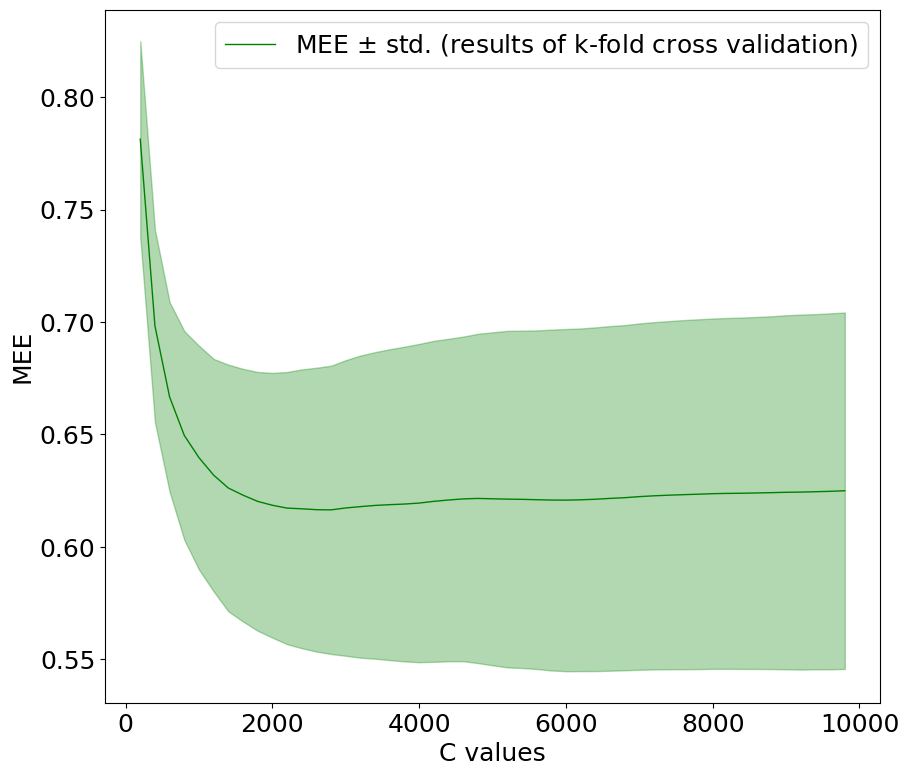

In [ ]:
#plot the values of mees changing the values of C
plot_mean_std(Cs,mees,mees_sd, label = 'C', color='green')

### Study the effect of the parameter $\varepsilon$.
Keeping C fixed, we want to study the effect of $\varepsilon$ on the validation error. 

In [ ]:
kernels = ['rbf']
Cs = [2800]
epsilons = np.arange(0.01,0.2,0.01)
#Best Hp: ['rbf', 2800, 0.1] with MEE = 0.6164267250857903 +- 0.0641407687516038

best_hyperparams, mees, mees_sd = perform_grid_search_kfold(kernels,
                          Cs,
                          epsilons,
                          degrees=[0],
                          gammas=['scale'],
                          k_folds=3,
                          x=X_train,
                          y=y_train,
                          return_sequence=True)

total number of grid search combinations explored: 19
1/19 Hyperparams: rbf 2800 0.01 0 scale
Final Results: kernel=rbf; C=2800; epsilon=0.01; deg = 0; gamma = scale --> train_mee = 0.1522 +- 0.00291
Final Results: kernel=rbf; C=2800; epsilon=0.01; deg = 0, gamma = scale --> val_mee = 0.6233 +- 0.06095
2/19 Hyperparams: rbf 2800 0.02 0 scale
Final Results: kernel=rbf; C=2800; epsilon=0.02; deg = 0; gamma = scale --> train_mee = 0.1557 +- 0.003075
Final Results: kernel=rbf; C=2800; epsilon=0.02; deg = 0, gamma = scale --> val_mee = 0.6192 +- 0.06115
3/19 Hyperparams: rbf 2800 0.03 0 scale
Final Results: kernel=rbf; C=2800; epsilon=0.03; deg = 0; gamma = scale --> train_mee = 0.1599 +- 0.003141
Final Results: kernel=rbf; C=2800; epsilon=0.03; deg = 0, gamma = scale --> val_mee = 0.6157 +- 0.06102
4/19 Hyperparams: rbf 2800 0.04 0 scale
Final Results: kernel=rbf; C=2800; epsilon=0.04; deg = 0; gamma = scale --> train_mee = 0.1646 +- 0.003463
Final Results: kernel=rbf; C=2800; epsilon=0.04

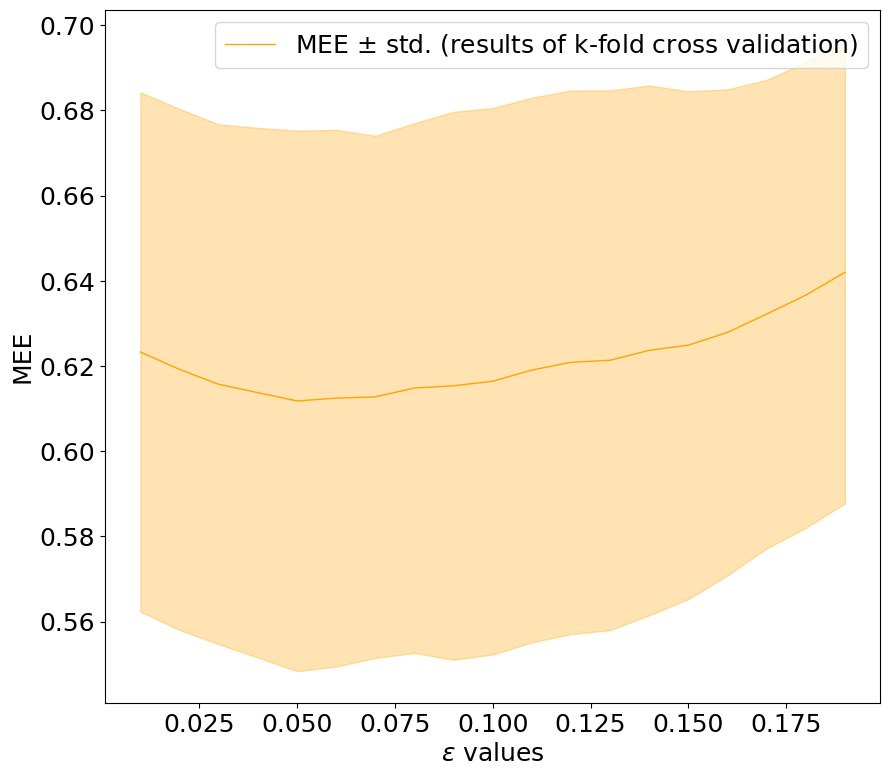

In [ ]:
#plot the values of mees changing the values of C
plot_mean_std(epsilons,mees,mees_sd, label='$\epsilon$', color='orange')

In [ ]:
#final model from model selection:
kernels = ['rbf']
Cs = [2800]
epsilons = [0.05]

best_hyperparams, mees, mees_sd = perform_grid_search_kfold(kernels,
                          Cs,
                          epsilons,
                          degrees=[0],
                          gammas=['scale'],
                          k_folds=3,
                          x=X_train,
                          y=y_train,
                          return_sequence=True)

total number of grid search combinations explored: 1
1/1 Hyperparams: rbf 2800 0.05 0 scale
Final Results: kernel=rbf; C=2800; epsilon=0.05; deg = 0; gamma = scale --> train_mee = 0.1696 +- 0.003877
Final Results: kernel=rbf; C=2800; epsilon=0.05; deg = 0, gamma = scale --> val_mee = 0.6118 +- 0.06344
Best Hp: ['rbf', 2800, 0.05, 0, 'scale'] with MEE = 0.6118105186695858 +- 0.06344420890556922


# Train the final model on all the training data
Finally, we train our best model on all the training data.
We test its performances on our internal test set.

In [ ]:
best_hyperparams = ['rbf', 2800, 0.05]
model = MultiSVM(*best_hyperparams)
model.fit(X_train,y_train)
print('Test MEE:',mean_euclidean_error(model.predict(X_test),y_test))

Test MEE: 0.5096504558449603


In [ ]:
# Check the number of support vectors
sv0 = model.svr0.support_vectors_.shape[0]
sv1 = model.svr1.support_vectors_.shape[0]
sv2 = model.svr2.support_vectors_.shape[0]

print("Number of support vectors:", sv0,sv1,sv2)

Number of support vectors: 639 651 603


# Load blind Test dataset

In [ ]:
dataset = np.loadtxt('ML-CUP23-TS.csv', delimiter=',')
X_blind = dataset[:,1:11]
y_blind = model.predict(X_blind)
id = np.arange(1,len(y_blind)+1, dtype=int)

## Save outputs in the required format
! remember to insert the correct date !

In [ ]:
import pandas as pd
import csv

file_path = 'output_cup.csv'

df = pd.DataFrame(y_blind, index=id, columns=['Column1', 'Column2', 'Column3'])
df.to_csv(file_path, header=False)

# Data to be added at the beginning
new_lines = [
    ['# Noemi Boni',' Lorenzo Zaffina'],
    ['# Cantucci_e_Soppressata'],
    ['# ML-CUP23'],
    ['# 30/01/2024']
]

# Read the existing content of the CSV file
with open(file_path, 'r', newline='') as csvfile:
    existing_content = list(csv.reader(csvfile))

# Insert the new lines at the beginning
existing_content[:0] = new_lines

# Write the updated content back to the CSV file
with open(file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(existing_content)

print(f'Data has been appended to the beginning of {file_path}')

Data has been appended to the beginning of output_cup.csv
